In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import requests
import os
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()  # reads the .env file automatically

True

In [20]:
import os, requests, pandas as pd

API_KEY = os.getenv("EIA_KEY")  # set first: export EIA_KEY="your_key"
BASE = "https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/"

COMMON = {
    "frequency": "daily",
    "data[0]": "value",
    "facets[respondent][]": "CAL",
    "facets[timezone][]": "Pacific",      # << your addition
    "start": "2019-01-01",
    "end":   "2025-09-27",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",         # keep your sort direction
    "length": 5000,
}

def fetch_all_daily():
    rows, offset, total = [], 0, None
    while True:
        params = COMMON.copy()
        params["api_key"] = API_KEY
        params["offset"]  = offset

        r = requests.get(BASE, params=params, timeout=60)
        r.raise_for_status()
        resp = r.json()["response"]

        if total is None:
            total = int(resp.get("total", 0))

        chunk = resp.get("data", [])
        rows.extend(chunk)
        print(f"Fetched {len(chunk):4d} rows @ offset {offset:,} "
              f"({len(rows):,}/{total:,})")

        if len(chunk) < params["length"] or offset + params["length"] >= total:
            break
        offset += params["length"]

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # Parse / clean
    # 'period' is daily like 'YYYY-MM-DD' (Pacific-local calendar day)
    df["period"] = pd.to_datetime(df["period"], format="%Y-%m-%d", errors="coerce")
    df["value"]  = pd.to_numeric(df["value"], errors="coerce")

    # Keep useful columns if present
    keep = ["period","respondent","respondent-name","fueltype","type-name",
            "timezone","value","value-units"]
    df = df[[c for c in keep if c in df.columns]].sort_values(["period","fueltype"])

    return df

if __name__ == "__main__":
    df_daily = fetch_all_daily()
    print("Daily shape:", df_daily.shape)
    if not df_daily.empty:
        df_daily.to_csv("eia_CAL_fueltype_daily_Pacific_2019_2025-09-27.csv", index=False)
        print(df_daily.head(10))

Fetched 5000 rows @ offset 0 (5,000/20,748)
Fetched 5000 rows @ offset 5,000 (10,000/20,748)
Fetched 5000 rows @ offset 10,000 (15,000/20,748)
Fetched 5000 rows @ offset 15,000 (20,000/20,748)
Fetched  748 rows @ offset 20,000 (20,748/20,748)
Daily shape: (20748, 8)
          period respondent respondent-name fueltype    type-name timezone  \
20740 2019-01-01        CAL      California      COL         Coal  Pacific   
20741 2019-01-01        CAL      California       NG  Natural Gas  Pacific   
20742 2019-01-01        CAL      California      NUC      Nuclear  Pacific   
20743 2019-01-01        CAL      California      OIL    Petroleum  Pacific   
20744 2019-01-01        CAL      California      OTH        Other  Pacific   
20745 2019-01-01        CAL      California      SUN        Solar  Pacific   
20746 2019-01-01        CAL      California      WAT        Hydro  Pacific   
20747 2019-01-01        CAL      California      WND         Wind  Pacific   
20732 2019-01-02        CAL    

In [21]:
df_daily.head()

,period,respondent,respondent-name,fueltype,type-name,timezone,value,value-units
20740,2019-01-01,CAL,California,COL,Coal,Pacific,36021,megawatthours
20741,2019-01-01,CAL,California,NG,Natural Gas,Pacific,199638,megawatthours
20742,2019-01-01,CAL,California,NUC,Nuclear,Pacific,54565,megawatthours
20743,2019-01-01,CAL,California,OIL,Petroleum,Pacific,2150,megawatthours
20744,2019-01-01,CAL,California,OTH,Other,Pacific,17823,megawatthours


In [22]:
df_daily.shape

(20748, 8)

In [7]:
def get_la_weather_data():
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 34.0522,
        "longitude": -118.2437,
        "start_date": "2019-01-01",
        "end_date": "2025-09-27",
        "daily": ["temperature_2m_mean", "precipitation_sum", "windspeed_10m_mean", 
                 "relative_humidity_2m_mean", "pressure_msl_mean"],
        "timezone": "America/Los_Angeles"
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'temperature_avg_c': data['daily']['temperature_2m_mean'],
        'precipitation_mm': data['daily']['precipitation_sum'],
        'wind_speed_kmh': data['daily']['windspeed_10m_mean'],
        'humidity_percent': data['daily']['relative_humidity_2m_mean'],
        'pressure_hpa': data['daily']['pressure_msl_mean']
    })
    
    return df

# Get the data
weather_data = get_la_weather_data()
print(weather_data.head())

        date  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
0 2019-01-01                8.4               0.0             9.5   
1 2019-01-02                8.9               0.0             5.4   
2 2019-01-03               11.3               0.0             5.6   
3 2019-01-04               12.2               0.0             6.6   
4 2019-01-05               11.1               8.0             9.0   

   humidity_percent  pressure_hpa  
0              23.0        1019.1  
1              20.0        1022.4  
2              30.0        1021.6  
3              37.0        1016.7  
4              77.0        1014.8  


In [8]:
weather_data.head()

,date,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
0,2019-01-01,8.4,0.0,9.5,23.0,1019.1
1,2019-01-02,8.9,0.0,5.4,20.0,1022.4
2,2019-01-03,11.3,0.0,5.6,30.0,1021.6
3,2019-01-04,12.2,0.0,6.6,37.0,1016.7
4,2019-01-05,11.1,8.0,9.0,77.0,1014.8


In [23]:
df_daily.dtypes

period             datetime64[ns]
respondent                 object
respondent-name            object
fueltype                   object
type-name                  object
timezone                   object
value                       int64
value-units                object
dtype: object

In [24]:
weather_data.dtypes

date                 datetime64[ns]
temperature_avg_c           float64
precipitation_mm            float64
wind_speed_kmh              float64
humidity_percent            float64
pressure_hpa                float64
dtype: object

In [25]:
df_daily.head()

,period,respondent,respondent-name,fueltype,type-name,timezone,value,value-units
20740,2019-01-01,CAL,California,COL,Coal,Pacific,36021,megawatthours
20741,2019-01-01,CAL,California,NG,Natural Gas,Pacific,199638,megawatthours
20742,2019-01-01,CAL,California,NUC,Nuclear,Pacific,54565,megawatthours
20743,2019-01-01,CAL,California,OIL,Petroleum,Pacific,2150,megawatthours
20744,2019-01-01,CAL,California,OTH,Other,Pacific,17823,megawatthours


In [26]:
# Sum values across all fuel types per day
daily_total = (
    df_daily.groupby("period", as_index=False)["value"]
            .sum()
            .rename(columns={"value": "total_value"})
)

# Now daily_total has only 'period' and 'total_value' columns
print(daily_total.head())

      period  total_value
0 2019-01-01       465701
1 2019-01-02       488901
2 2019-01-03       484062
3 2019-01-04       477305
4 2019-01-05       451001


In [27]:
daily_total.head()

,period,total_value
0,2019-01-01,465701
1,2019-01-02,488901
2,2019-01-03,484062
3,2019-01-04,477305
4,2019-01-05,451001


In [28]:
daily_total.shape

(2462, 2)

In [29]:
df_merged = pd.merge(daily_total, weather_data, left_on='period', right_on='date', how='inner')

In [30]:
df_merged.shape

(2462, 8)

In [31]:
df_merged.head()

,period,total_value,date,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
0,2019-01-01,465701,2019-01-01,8.4,0.0,9.5,23.0,1019.1
1,2019-01-02,488901,2019-01-02,8.9,0.0,5.4,20.0,1022.4
2,2019-01-03,484062,2019-01-03,11.3,0.0,5.6,30.0,1021.6
3,2019-01-04,477305,2019-01-04,12.2,0.0,6.6,37.0,1016.7
4,2019-01-05,451001,2019-01-05,11.1,8.0,9.0,77.0,1014.8


In [32]:
df_merged.describe()

,period,total_value,date,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
count,2462,2462.000000,2462,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,2022-05-15 12:00:00,575890.448010,2022-05-15 12:00:00,17.542398,1.296138,7.915163,63.458130,1015.020976
min,2019-01-01 00:00:00,91499.000000,2019-01-01 00:00:00,6.300000,0.000000,1.500000,9.000000,1000.900000
25%,2020-09-07 06:00:00,488972.250000,2020-09-07 06:00:00,13.600000,0.000000,6.400000,56.000000,1012.500000
50%,2022-05-15 12:00:00,560277.000000,2022-05-15 12:00:00,17.500000,0.000000,7.800000,68.000000,1014.500000
75%,2024-01-20 18:00:00,642445.500000,2024-01-20 18:00:00,21.300000,0.000000,9.000000,74.000000,1017.500000
max,2025-09-27 00:00:00,986686.000000,2025-09-27 00:00:00,34.400000,91.900000,26.900000,96.000000,1028.500000
std,NaN,119562.445548,NaN,4.780376,6.189210,2.551164,16.736344,3.715146


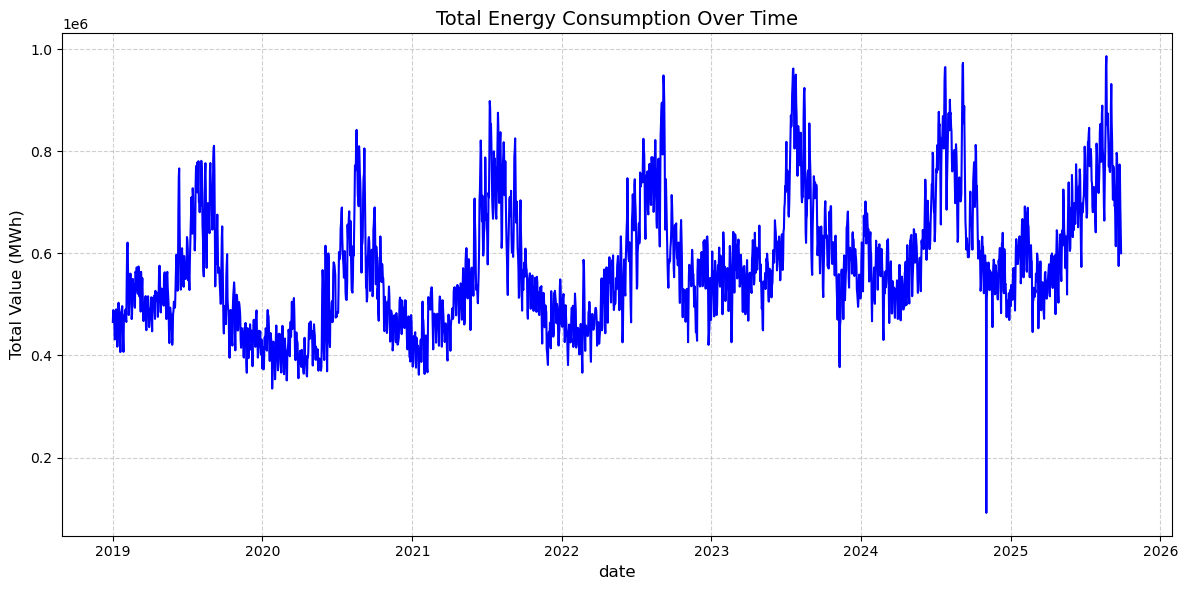

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(data=df_merged, x="date", y="total_value", color="blue")

plt.title("Total Energy Consumption Over Time", fontsize=14)
plt.xlabel("date", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

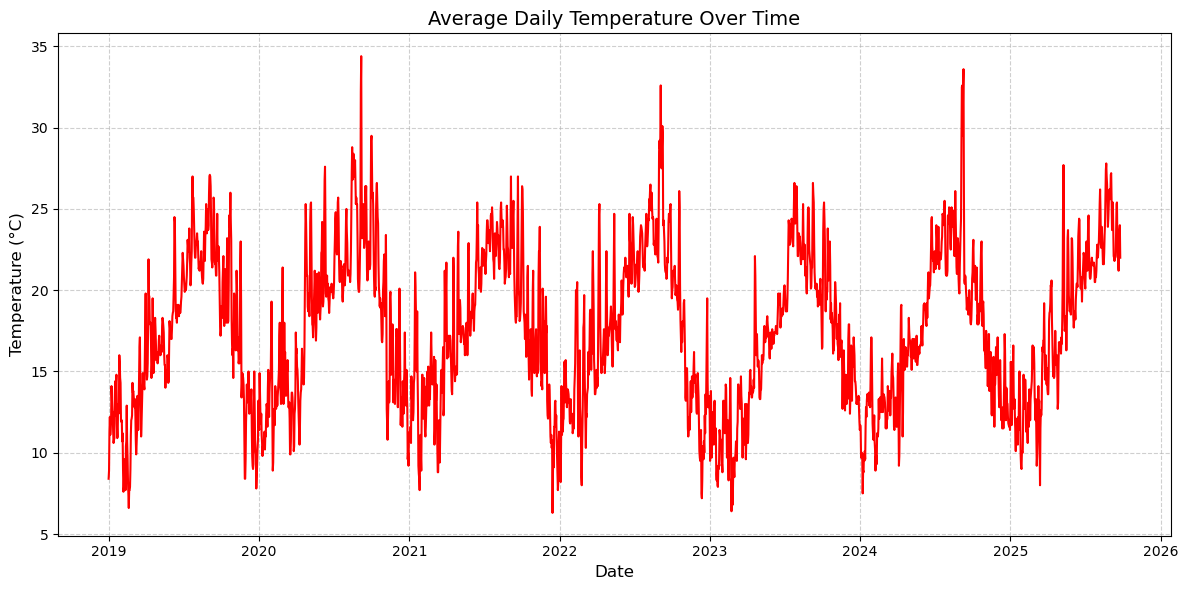

In [34]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_merged, x="date", y="temperature_avg_c", color="red")

plt.title("Average Daily Temperature Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

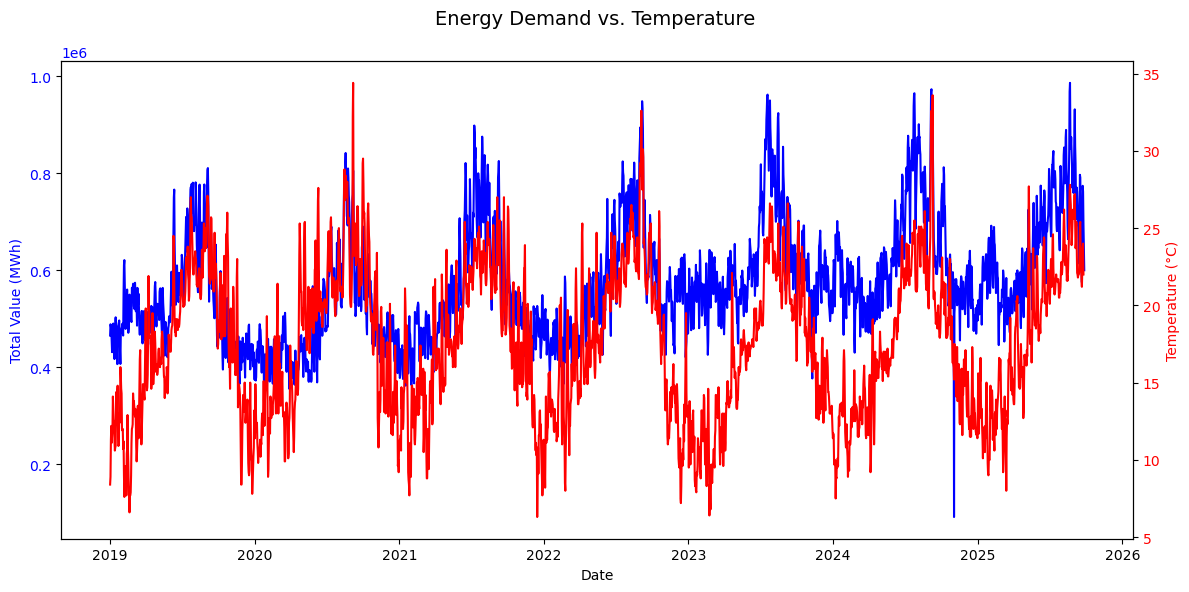

In [35]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot total energy
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Value (MWh)", color="blue")
ax1.plot(df_merged["date"], df_merged["total_value"], color="blue", label="Total Value")
ax1.tick_params(axis="y", labelcolor="blue")

# Twin axis for temperature
ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (°C)", color="red")
ax2.plot(df_merged["date"], df_merged["temperature_avg_c"], color="red", label="Temperature")
ax2.tick_params(axis="y", labelcolor="red")

fig.suptitle("Energy Demand vs. Temperature", fontsize=14)
fig.tight_layout()
plt.show()

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_35642/3981550314.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


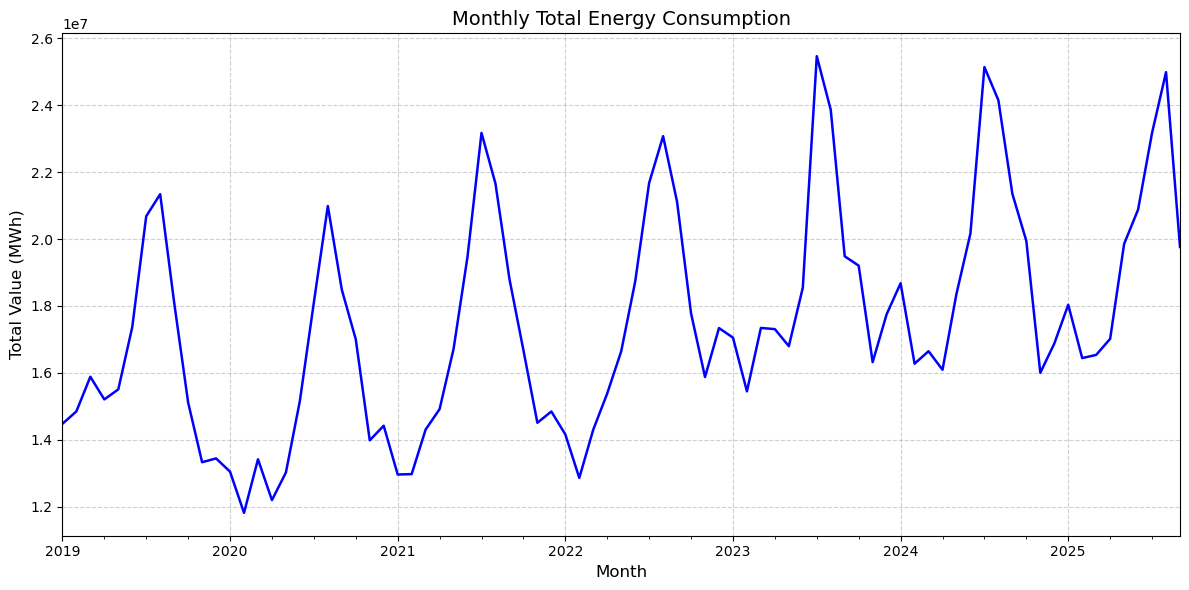

In [36]:
# Resample by month and sum values
monthly_total = (
    df_merged.set_index("date")["total_value"]
             .resample("M")
             .sum()
)

# Plot
plt.figure(figsize=(12,6))
monthly_total.plot(kind="line", color="blue", linewidth=1.8)

plt.title("Monthly Total Energy Consumption", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

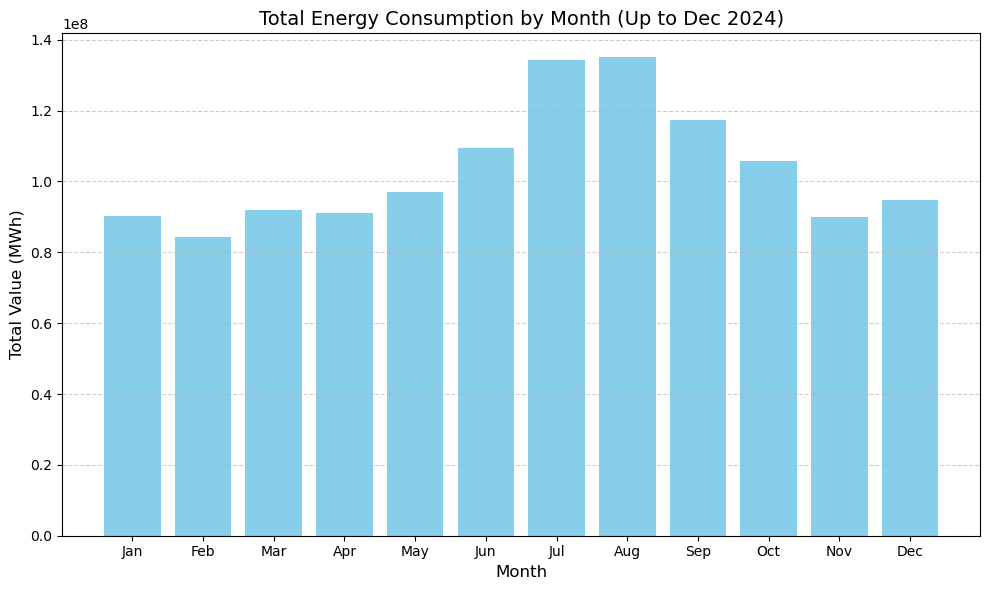

In [39]:
# Filter up to Dec 31, 2024
df_filtered = df_merged[df_merged["date"] <= "2024-12-31"]

# Group by month across all years
monthly_totals = (
    df_filtered.groupby(df_filtered["date"].dt.month)["total_value"]
               .sum()
)

# Month labels
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Plot
plt.figure(figsize=(10,6))
plt.bar(month_labels, monthly_totals, color="skyblue")

plt.title("Total Energy Consumption by Month (Up to Dec 2024)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

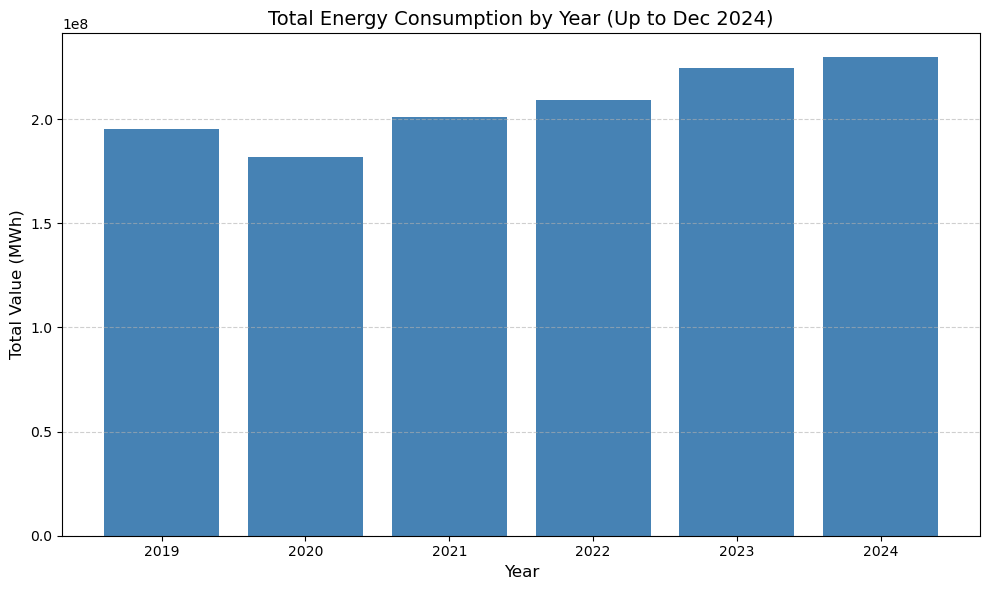

In [40]:
# Group by year
yearly_totals = (
    df_filtered.groupby(df_filtered["date"].dt.year)["total_value"]
               .sum()
)

# Plot
plt.figure(figsize=(10,6))
plt.bar(yearly_totals.index.astype(str), yearly_totals.values, color="steelblue")

plt.title("Total Energy Consumption by Year (Up to Dec 2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [41]:
df_merged.set_index("date", inplace=True)
df_merged.head()

,period,total_value,temperature_avg_c,precipitation_mm,wind_speed_kmh,humidity_percent,pressure_hpa
date,,,,,,,
2019-01-01,2019-01-01,465701,8.4,0.0,9.5,23.0,1019.1
2019-01-02,2019-01-02,488901,8.9,0.0,5.4,20.0,1022.4
2019-01-03,2019-01-03,484062,11.3,0.0,5.6,30.0,1021.6
2019-01-04,2019-01-04,477305,12.2,0.0,6.6,37.0,1016.7
2019-01-05,2019-01-05,451001,11.1,8.0,9.0,77.0,1014.8


In [43]:
df_merged.drop(columns=["period"], inplace=True)

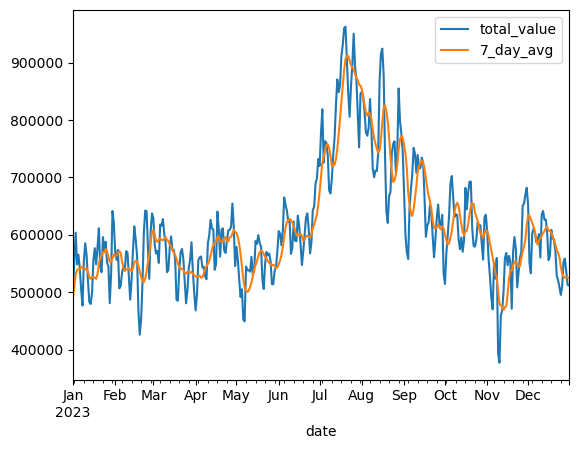

In [46]:
df_merged['7_day_avg'] = df_merged['total_value'].rolling(window=7).mean()
df_merged[['total_value', '7_day_avg']].loc['2023'].plot()
plt.show()

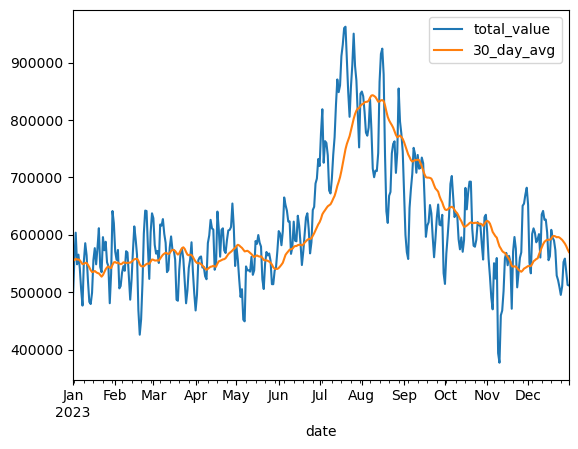

In [47]:
df_merged['30_day_avg'] = df_merged['total_value'].rolling(window=30).mean()
df_merged[['total_value', '30_day_avg']].loc['2023'].plot()
plt.show()

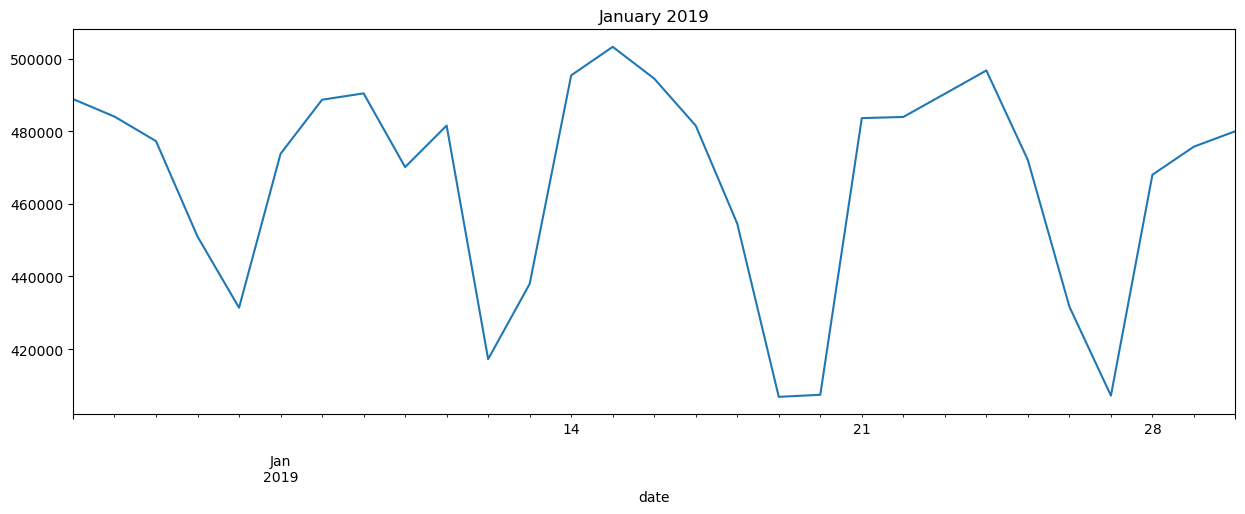

In [51]:
df_merged['total_value'].loc[(df_merged.index > '2019-01-01') & (df_merged.index <'2019-01-31')].plot(figsize=(15,5), title='January 2019')
plt.show()

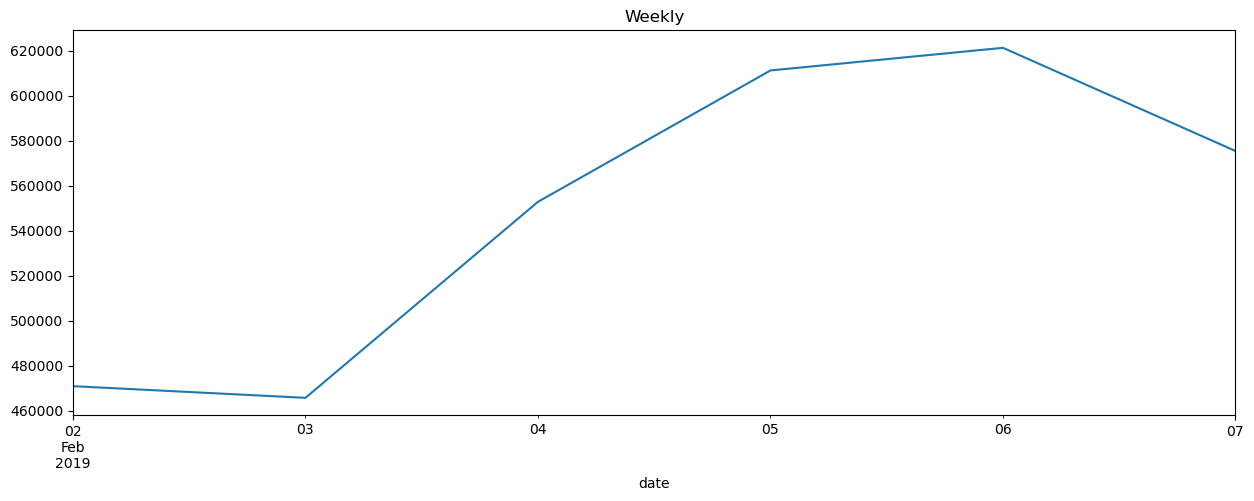

In [66]:
df_merged['total_value'].loc[(df_merged.index > '2019-02-01') & (df_merged.index <'2019-02-08')].plot(figsize=(15,5), title='Weekly')
plt.show()

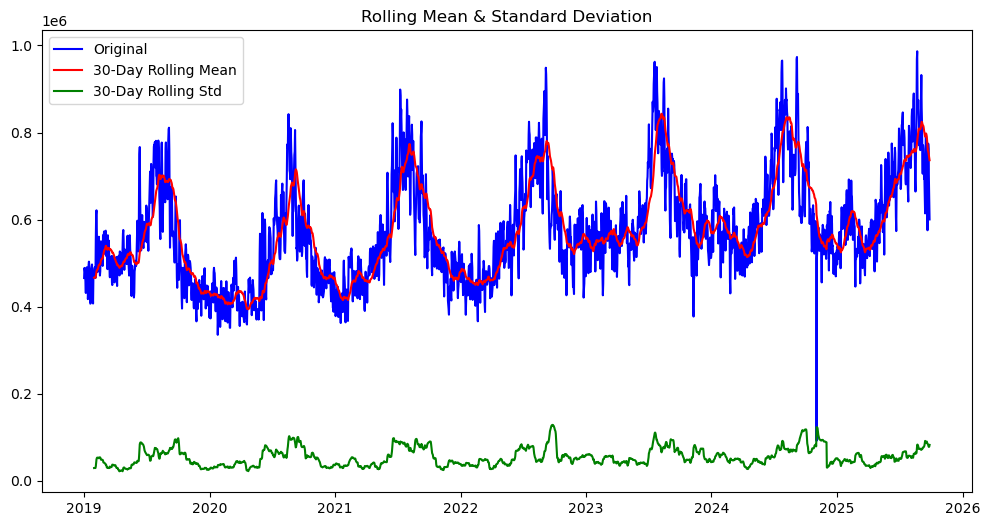

In [53]:
# Check for statonarity
# Plot 30 day folling mean and std
rolling_mean = df_merged['total_value'].rolling(window=30).mean()
rolling_std = df_merged['total_value'].rolling(window=30).std()
plt.figure(figsize=(12,6))
plt.plot(df_merged['total_value'], label='Original', color='blue')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red')
plt.plot(rolling_std, label='30-Day Rolling Std', color='green')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()


In [57]:
df_merged.shape

(2462, 8)

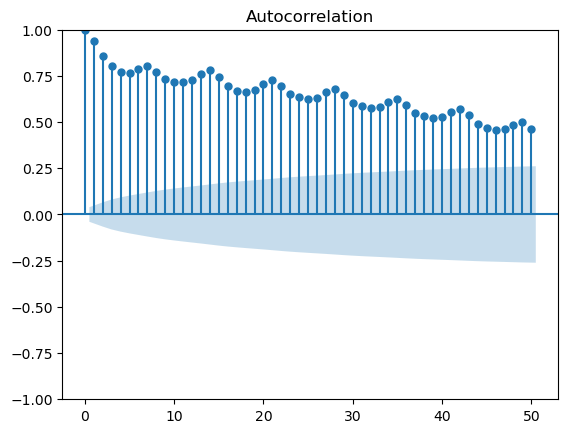

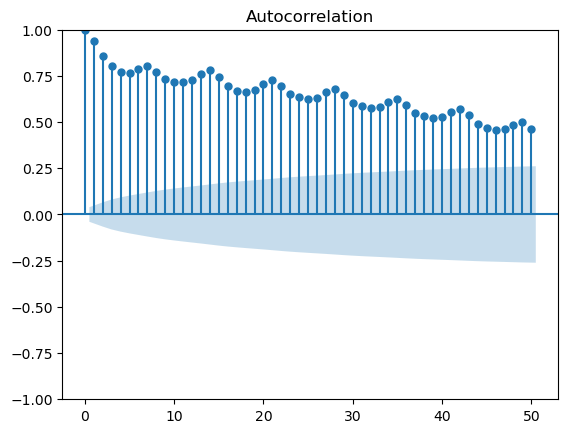

In [58]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot up to 40 lags
plot_acf(df_merged["total_value"], lags=50)

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_merged["total_value"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -2.949669278717941
p-value: 0.03986953474894958
Critical Value 1%: -3.4330383807110296
Critical Value 5%: -2.8627276983827623
Critical Value 10%: -2.5674022602026403


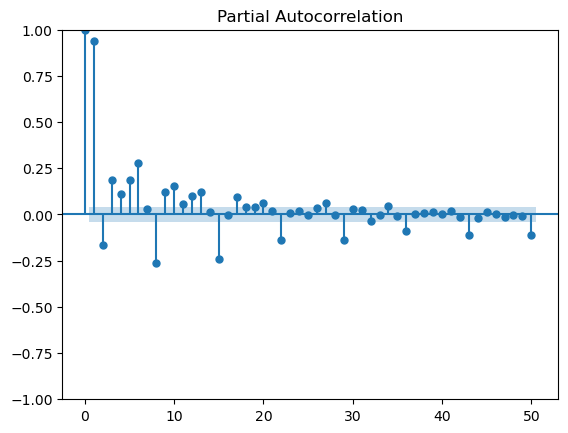

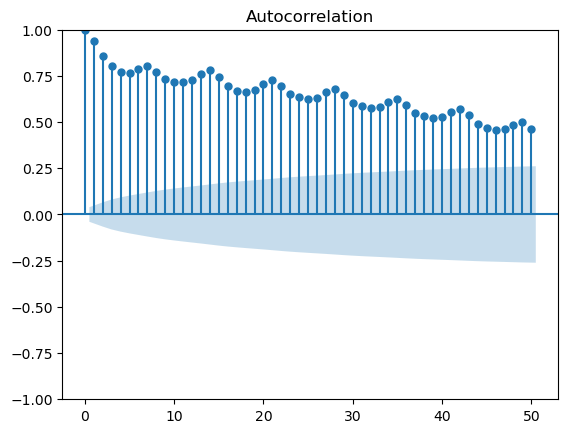

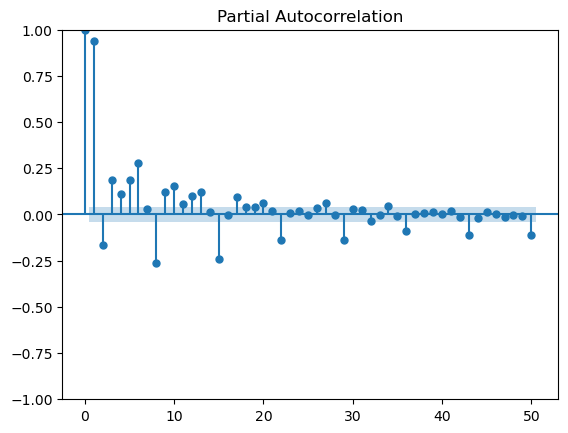

In [60]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_merged["total_value"], lags=50)
plot_pacf(df_merged["total_value"], lags=50)

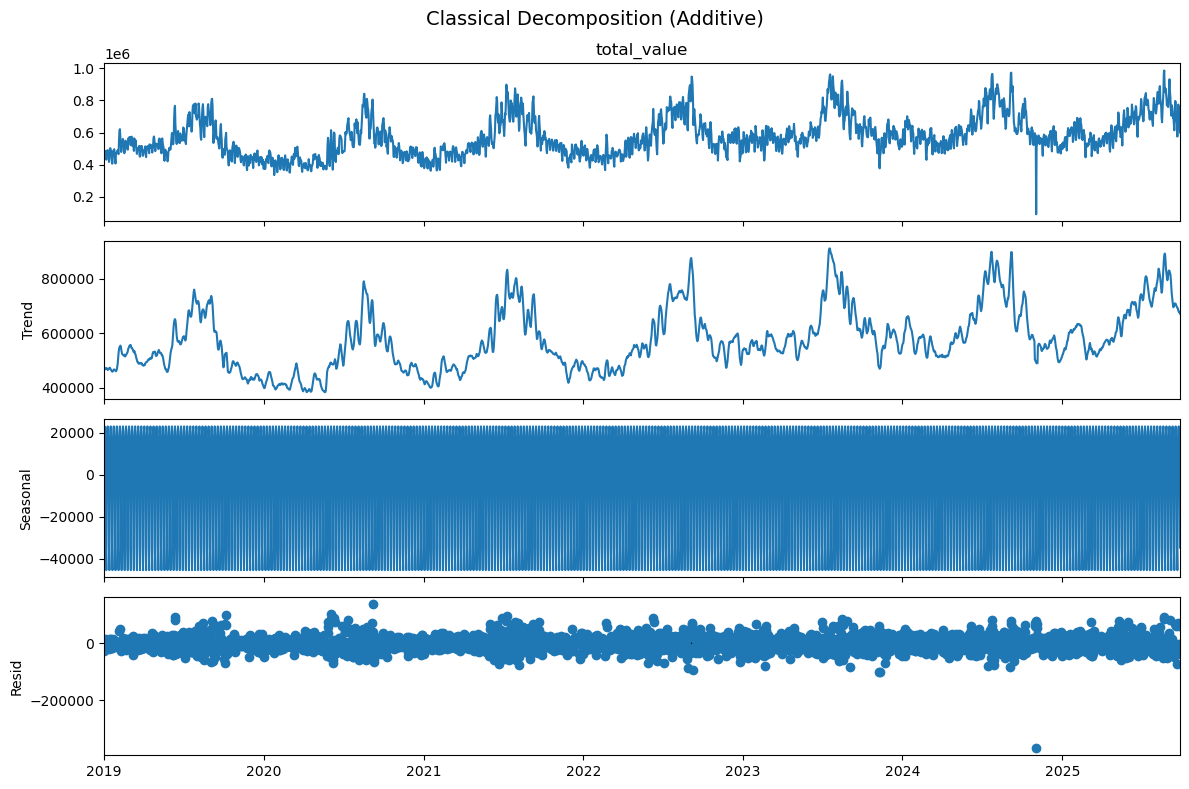

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# ---- Prep your series ----
# df must have a datetime column and a numeric target (e.g., 'date', 'total_value')
df = df_merged.copy()
#df["date"] = pd.to_datetime(df["date"])
#df = df.set_index("date").sort_index()

# If daily data with weekly seasonality, period=7
# If hourly data with daily seasonality, period=24 (or 168 for weekly)
period = 7  # change to 24/168/12/etc. based on your frequency

# Option: handle small gaps
y = df["total_value"].asfreq("D")  # "D" for daily; use "H" for hourly
y = y.interpolate(limit_direction="both")

# ---- Decompose ----
result = seasonal_decompose(y, model="additive", period=period, extrapolate_trend="freq")

# ---- Plot ----
fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Classical Decomposition (Additive)", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

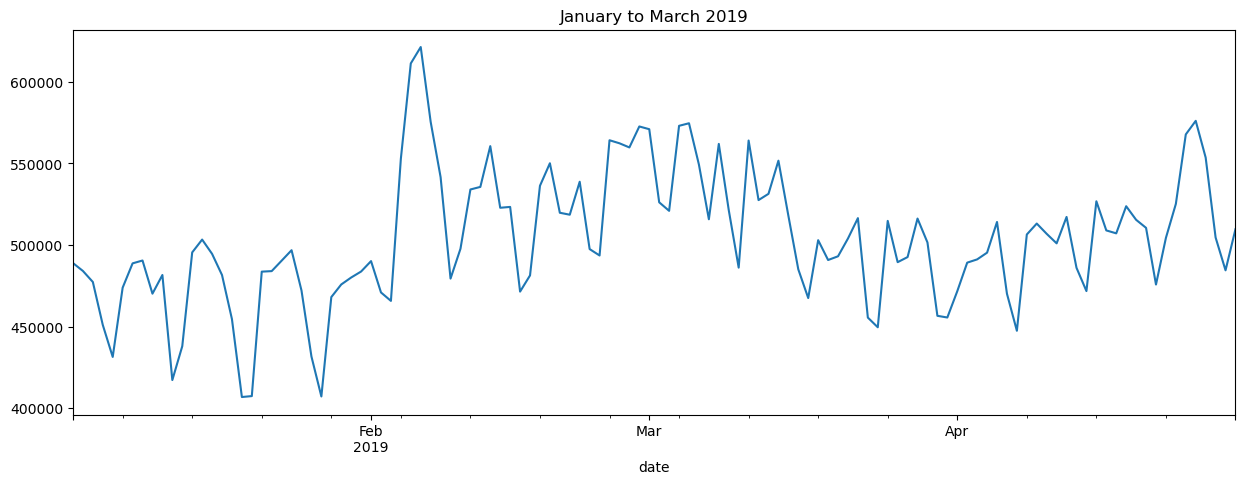

In [67]:
df_merged['total_value'].loc[(df_merged.index > '2019-01-01') & (df_merged.index <'2019-04-30')].plot(figsize=(15,5), title='January to March 2019')
plt.show()

In [71]:
list(df_merged.loc['2019-01-01':'2019-02-18']['total_value'])

[465701,
 488901,
 484062,
 477305,
 451001,
 431380,
 473814,
 488715,
 490462,
 470146,
 481587,
 417211,
 437955,
 495428,
 503286,
 494536,
 481566,
 454553,
 406819,
 407390,
 483640,
 483964,
 490352,
 496774,
 472077,
 431673,
 407148,
 468045,
 475778,
 480045,
 483722,
 490096,
 470893,
 465715,
 552830,
 611213,
 621268,
 575418,
 541542,
 479383,
 497657,
 533983,
 535561,
 560545,
 522778,
 523296,
 471411,
 481327,
 536245]

In [84]:
diff_7 = df_merged['total_value'].diff(periods=7)["2019-01-01":"2025-09-27"]

<Axes: title={'center': '7-day differencing Jan 2019 to Sept 2025'}, xlabel='date'>

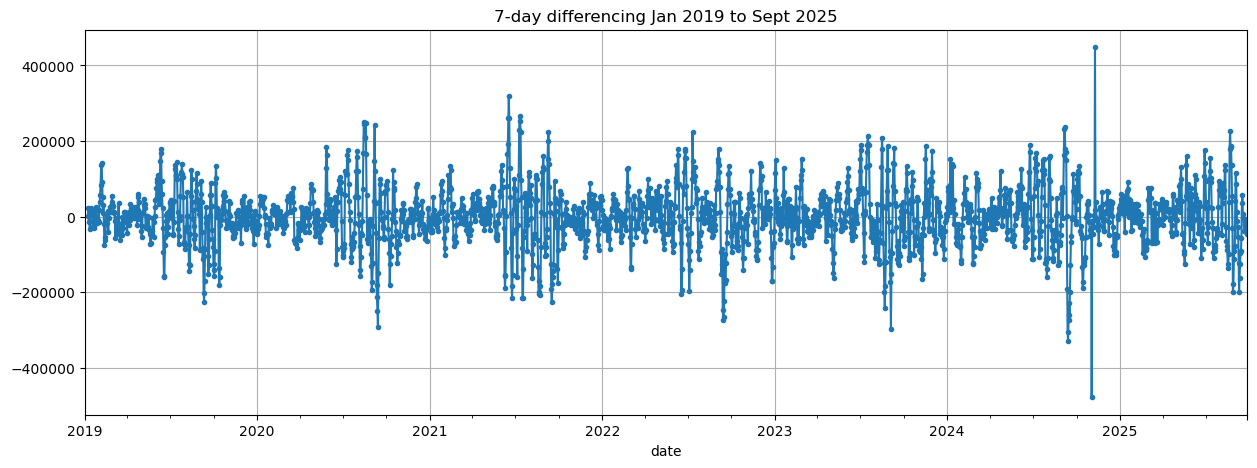

In [85]:
diff_7.plot(figsize=(15,5), grid=True, marker=".", title='7-day differencing Jan 2019 to Sept 2025')   

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_35642/2522324074.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_merged['total_value'].resample('M').mean()


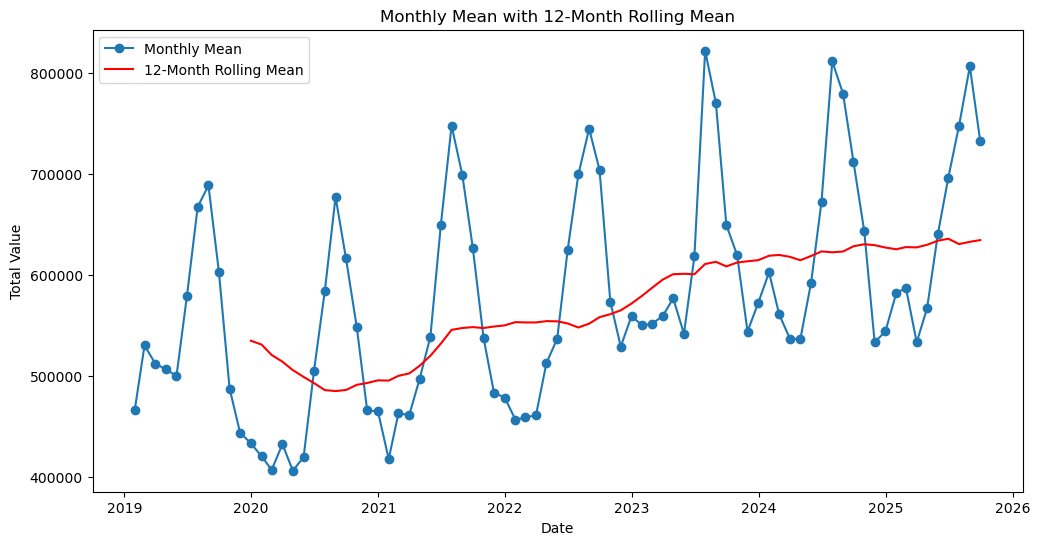

In [78]:
df_monthly = df_merged['total_value'].resample('M').mean()
rolling_mean_12 = df_monthly.rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_monthly, label='Monthly Mean', marker='o')
ax.plot(rolling_mean_12, label='12-Month Rolling Mean', color='red')
ax.set_title('Monthly Mean with 12-Month Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Total Value')
ax.legend()
plt.show()


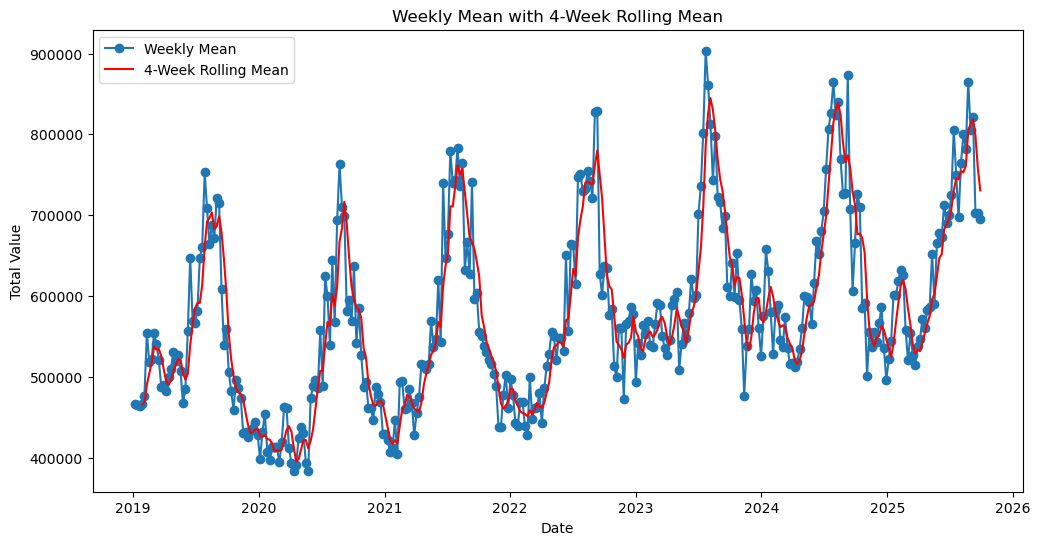

In [79]:
df_weekly = df_merged['total_value'].resample('W').mean()
rolling_mean_4 = df_weekly.rolling(window=4).mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_weekly, label='Weekly Mean', marker='o')
ax.plot(rolling_mean_4, label='4-Week Rolling Mean', color='red')
ax.set_title('Weekly Mean with 4-Week Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Total Value')
ax.legend()
plt.show()


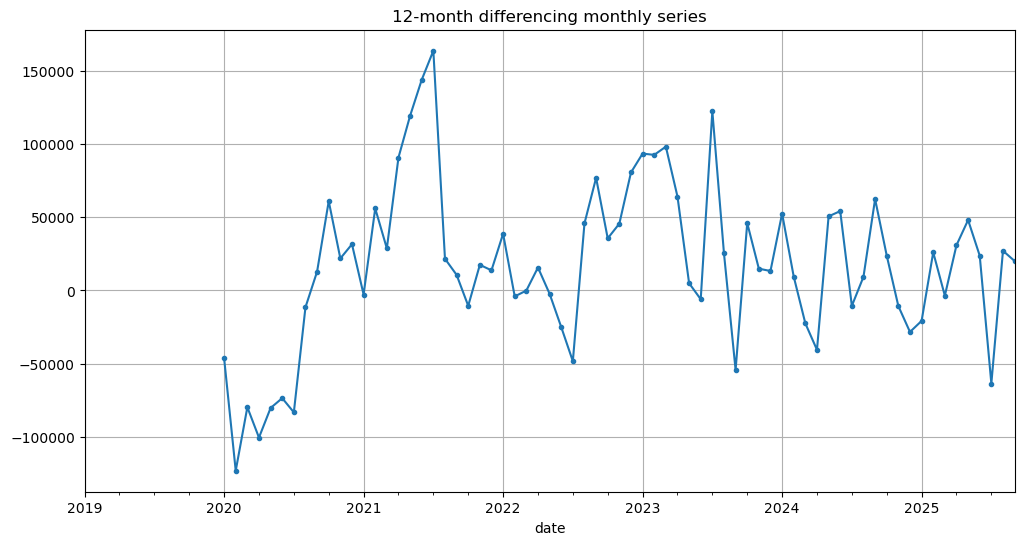

In [81]:
df_monthly.diff(12).plot(grid=True, marker=".", figsize=(12,6), title='12-month differencing monthly series')
plt.show()

Best by AIC: (2, 0, 2) (1, 1, 1, 7) AIC: 45955.84
Validation  MAE: 105,921.872   RMSE: 139,913.109


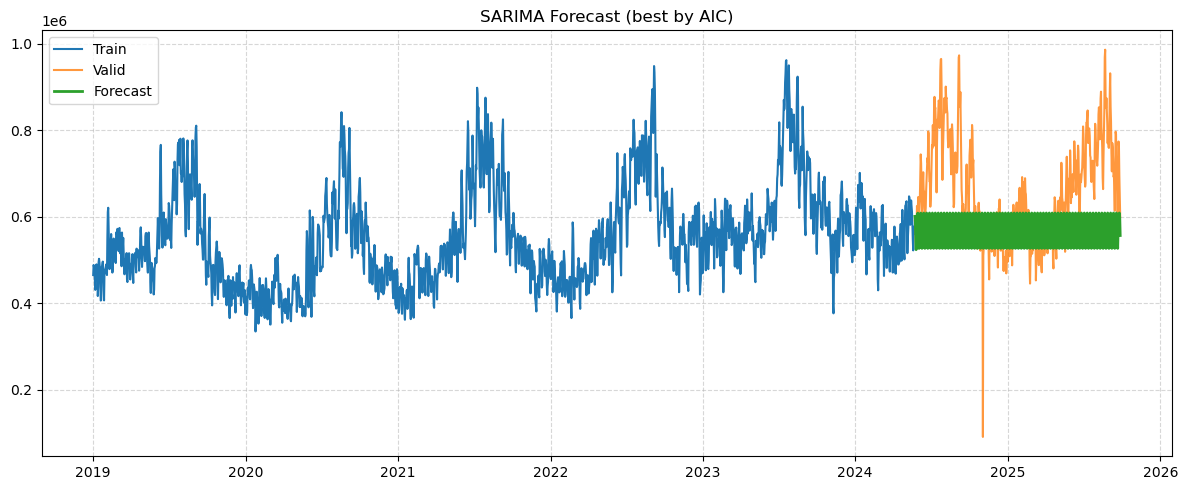

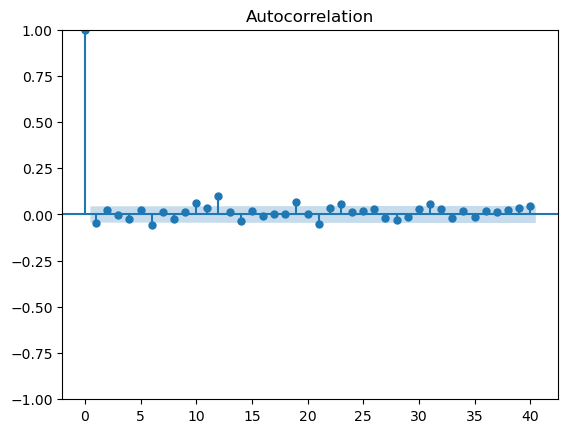

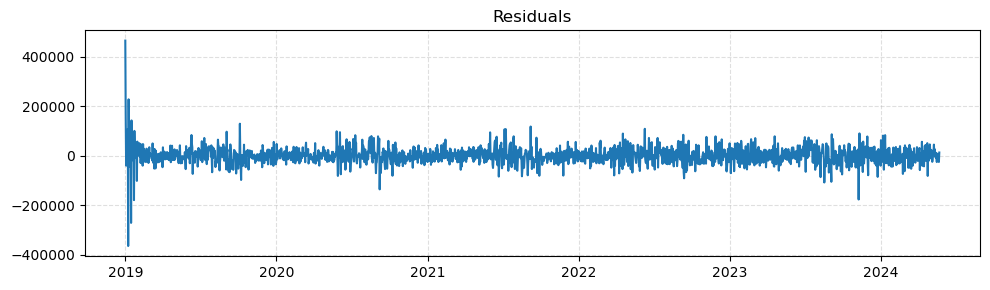

In [90]:
import pandas as pd, numpy as np, itertools, warnings
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# --- 0) Build target series from your prepared date column ---
# If your date is already the index, comment out the next line.
y = df_merged["total_value"].asfreq("D").interpolate(limit_direction="both")

# --- 1) Train/valid split (time-based) ---
valid_frac = 0.2
n = len(y); k = int(np.floor((1 - valid_frac) * n))
y_tr, y_va = y.iloc[:k], y.iloc[k:]

# --- 2) SARIMA grid search (parsimonious) ---
def sarima_grid(y_train, m=7, pqr=range(0,3), PQR=range(0,2)):
    best = {"aic": np.inf, "order": None, "sorder": None, "res": None}
    for p,d,q in itertools.product(pqr, repeat=3):
        for P,D,Q in itertools.product(PQR, repeat=3):
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    y_train,
                    order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = mod.fit(disp=False)
                if res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": (p,d,q), "sorder": (P,D,Q,m), "res": res}
            except:
                pass
    return best

m = 7  # weekly seasonality for daily data
best = sarima_grid(y_tr, m=m, pqr=range(0,3), PQR=range(0,2))
print("Best by AIC:", best["order"], best["sorder"], "AIC:", round(best["aic"],2))

# --- 3) Forecast & evaluate ---
n_va = len(y_va)
y_hat = best["res"].get_forecast(steps=n_va).predicted_mean
mae = mean_absolute_error(y_va, y_hat)
rmse = sqrt(mean_squared_error(y_va, y_hat))
print(f"Validation  MAE: {mae:,.3f}   RMSE: {rmse:,.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_tr.index, y_tr, label="Train")
plt.plot(y_va.index, y_va, label="Valid", alpha=0.8)
plt.plot(y_hat.index, y_hat, label="Forecast", linewidth=2)
plt.title("SARIMA Forecast (best by AIC)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

# --- 4) Quick residual checks (should look like white noise) ---
resid = best["res"].resid.dropna()
fig = sm.graphics.tsa.plot_acf(resid, lags=40); plt.show()
plt.figure(figsize=(10,3)); plt.plot(resid); plt.title("Residuals"); plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout(); plt.show()